In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictor

/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <8E58E83E-9235-3324-9B6B-260614F85F69> /Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F008E7E7-AB21-3358-8168-A868137DB04F> /Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/tor

## (modified) MovingMNIST

In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 3

# Create a dataset using the modified MovingMNIST
MMMNIST = ModMovingMNIST(
    canvas_size=(32, 32),
    digit_size=(12, 12),
    pixel_noise=0.05,
    velocity_noise=0.25
)

# Create a train set (500), test set (50), and validation set (50)
x, y = MMMNIST.create_dataset(500, input_timesteps, n_digits=1)
x_test, y_test = MMMNIST.create_dataset(50, input_timesteps, n_digits=1)
x_val, y_val = MMMNIST.create_dataset(50, input_timesteps, n_digits=1)

## Modelling

In [3]:
model_kwargs = dict(
    hidden_size=64,
    dropout=0.1,
    input_timesteps=input_timesteps
    )

model = NextFramePredictor(experiment_name='test', decompose=True, input_features=1, **model_kwargs)

### Threshold selection

Test different thresholds and check the image reconstruction.
We want to ensure the reconstruction keeps all detail we wish to 
preserve. 

Here, 0.1 is too high as all pixels and we get a single cell representing 
the entire image. Obviously bad. With 0.001 we don't get any data reduction
and the number of cells is equal to the number of pixels. This would work, 
and would be equivalent to setting decompose=False. 

A threshold of 0.01 keeps the digit in full detail while reducing the number
of cells significantly. 

Note that you can check different frames in your input to be more confident
that threshold works across the dataset and not just for the a single set of 
frames. 

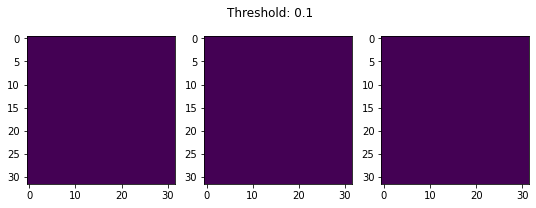

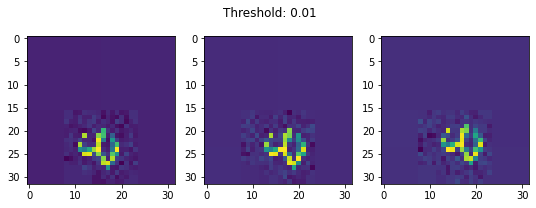

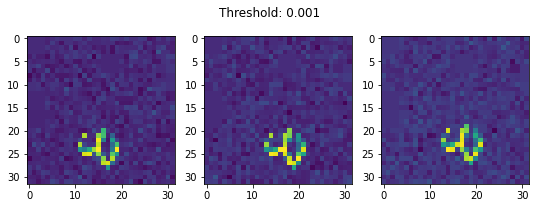

In [4]:
frame_index = 3

fig, axs = model.test_threshold(x, thresh=0.1, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.01, frame_index=frame_index)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.001, frame_index=frame_index)
plt.show()

### Training

In [5]:
model.set_thresh(0.01)  # Set the threshold based on the plots above

lr = 0.01

model.train(x, y, x_test, y_test, lr=lr, n_epochs=20)  # Train for 20 epochs
model.score(x_val, y_val)  # Check the MSE on the validation set

/Users/zach/Documents/mpnn-lstm/mpnnlstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_func(y_hat, torch.tensor(graph.y[0]))
/Users/zach/Documents/mpnn-lstm/mpnnlstm.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_func(y_hat, torch.tensor(graph.y[0, ..., :1]))


Epoch 0 train MSE: 0.0628, test MSE: 0.0580, lr: 0.0100, time_per_epoch: 13.9
Epoch 1 train MSE: 0.0592, test MSE: 0.0564, lr: 0.0100, time_per_epoch: 13.8
Epoch 2 train MSE: 0.0574, test MSE: 0.0555, lr: 0.0100, time_per_epoch: 13.9
Epoch 3 train MSE: 0.0550, test MSE: 0.0528, lr: 0.0100, time_per_epoch: 14.3
Epoch 4 train MSE: 0.0515, test MSE: 0.0496, lr: 0.0100, time_per_epoch: 14.5
Epoch 5 train MSE: 0.0492, test MSE: 0.0492, lr: 0.0100, time_per_epoch: 14.6
Epoch 6 train MSE: 0.0482, test MSE: 0.0487, lr: 0.0100, time_per_epoch: 14.8
Epoch 7 train MSE: 0.0476, test MSE: 0.0489, lr: 0.0100, time_per_epoch: 15.0
Epoch 8 train MSE: 0.0469, test MSE: 0.0488, lr: 0.0100, time_per_epoch: 15.1
Epoch 9 train MSE: 0.0464, test MSE: 0.0493, lr: 0.0095, time_per_epoch: 15.7
Epoch 10 train MSE: 0.0460, test MSE: 0.0485, lr: 0.0095, time_per_epoch: 15.6
Epoch 11 train MSE: 0.0458, test MSE: 0.0476, lr: 0.0095, time_per_epoch: 15.7
Epoch 12 train MSE: 0.0451, test MSE: 0.0481, lr: 0.0095, time

tensor(0.0108)

### Visualize results

In [6]:
# Get predictions on the validation set
y_hat = model.predict(x_val)

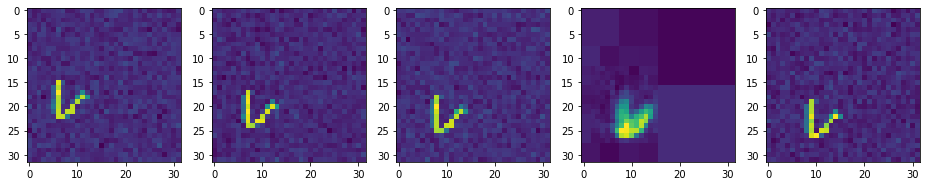

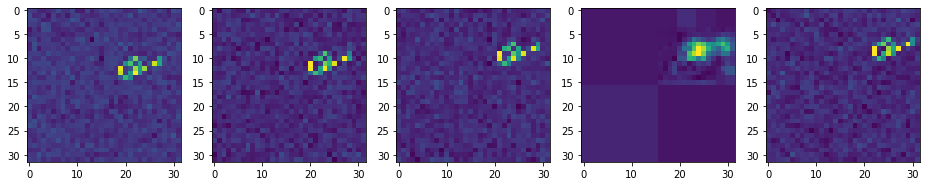

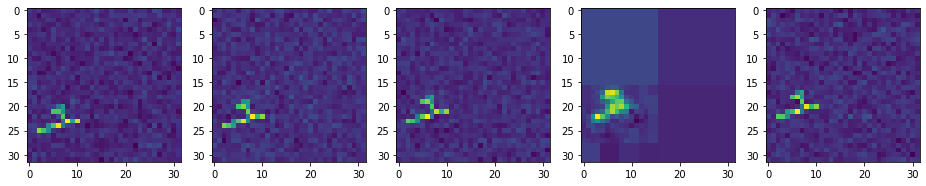

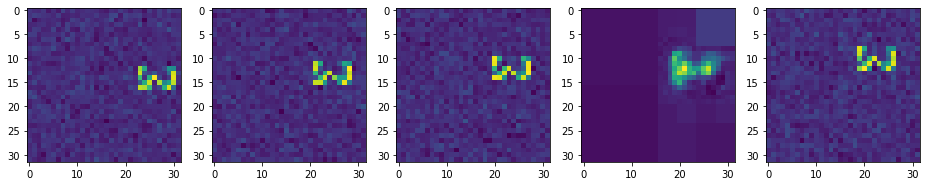

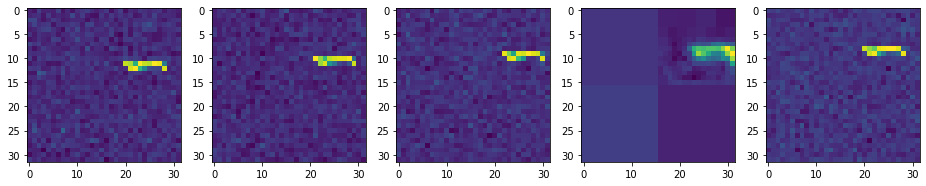

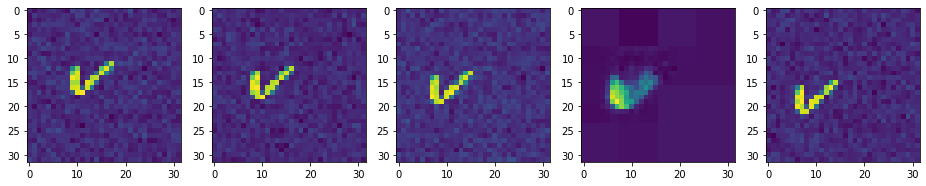

In [7]:
# Plot some example 
for i in range(6):
    fig, axs = plt.subplots(1, 5, figsize=(16, 4))
    
    # Inputs
    axs[0].imshow(x_val[i][0, ..., 0])
    axs[1].imshow(x_val[i][1, ..., 0])
    axs[2].imshow(x_val[i][2, ..., 0])
    
    axs[3].imshow(y_hat[i][0])  # Prediction
    axs[4].imshow(y_val[i][0, ..., 0])  # Truth

<AxesSubplot: >

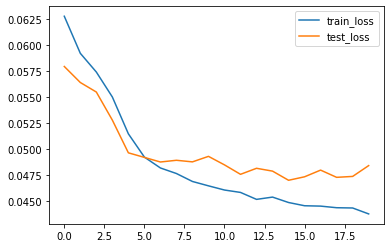

In [9]:
model.loss.plot()